# **Notebook para Tesis**

Aqui hare el analisis y seleccion de caracteristicas

In [1]:
# Importar librerias necesarias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Interpolación
from scipy.interpolate import PchipInterpolator

from scipy.fft import fft, fftfreq

## dotenv
from dotenv import load_dotenv
# Cargar variables de entorno
load_dotenv()

True

## **Lectura de Archivos**

In [ ]:
from data_load import get_pulses_df

files_amount = 1 ## Número de archivos a cargar, 0 para cargar todos
data = get_pulses_df(os.getenv("pulses_csv_path"), files_amount) ## Cargar datos 

In [3]:
data

,Unnamed: 0,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15
0,6,19,14,6,2,2,1,1,0,0,0,0,0,0,0,0,0
1,11,3,5,3,1,0,0,0,0,0,0,0,0,0,0,0,0
2,13,2,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0
3,24,2,7,3,1,0,1,0,0,0,0,0,0,0,0,0,0
4,27,9,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962129,4666395,40,45,21,15,5,5,3,1,1,0,0,0,0,0,0,0
962130,4666399,71,49,24,11,6,3,0,2,0,0,0,1,0,0,0,0
962131,4666402,55,36,22,12,3,5,3,2,0,0,0,0,0,0,0,0
962132,4666408,3,14,1,0,1,2,0,0,1,0,0,0,0,0,0,0


### **Muestreo de Datos**

In [4]:
# Muestro los datos
print(data.head())

   Unnamed: 0  s_0  s_1  s_2  s_3  s_4  s_5  s_6  s_7  s_8  s_9  s_10  s_11  \
0           6   19   14    6    2    2    1    1    0    0    0     0     0   
1          11    3    5    3    1    0    0    0    0    0    0     0     0   
2          13    2    1    0    2    1    0    0    0    0    0     0     0   
3          24    2    7    3    1    0    1    0    0    0    0     0     0   
4          27    9    5    3    0    0    0    0    0    0    0     0     0   

   s_12  s_13  s_14  s_15  
0     0     0     0     0  
1     0     0     0     0  
2     0     0     0     0  
3     0     0     0     0  
4     0     0     0     0  


## **Interpolación**

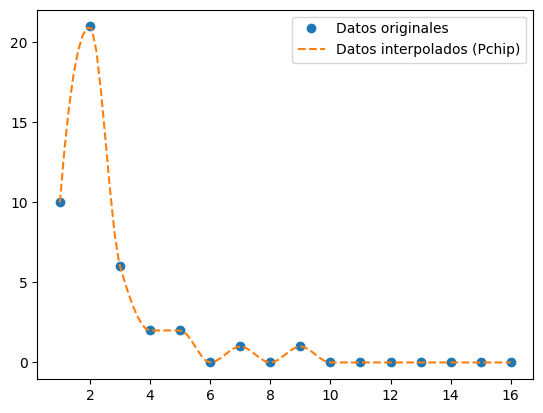

In [5]:
test = data.iloc[10, 1:].values # Tomo la segunda fila de data

x = np.arange(1, len(test)+1) 
y = test 

# cs = CubicSpline(x[mask], y[mask]) 
p = PchipInterpolator(x, y) 
xnew = np.linspace(1, len(test), num=100)
ynew = p(xnew)

plt.plot(x, y, 'o', label='Datos originales') 
# plt.plot(xnew, cs(xnew), '-', label='Datos interpolados (Spline Cúbico)') #Conecta los puntos pero desvia de ellos un poco 
plt.plot(xnew, ynew, '--', label='Datos interpolados (Pchip)') #Conecta los puntos de manera suave
plt.legend()
plt.show()

## **Features**

In [6]:
## Amplitude
amplitude_max = np.max(ynew) 
print(f"amplitud: {amplitude_max}")

## Width
threshold = 0.35 * amplitude_max # Definir el umbral 
above_threshold = np.where(ynew > threshold)[0] # Encuentra los índices donde el valor es mayor al umbral 
width = pulse_width = xnew[above_threshold[-1]] - xnew[above_threshold[0]] if len(above_threshold) > 0 else 0 # Calcular el ancho de pulso
print(f"ancho: {width}, inicio: {xnew[above_threshold[0]]}, fin: {xnew[above_threshold[-1]]}")

## Rise and Fall time
amplitude_10 = 0.1 * amplitude_max # Definir el umbral inferior
amplitude_90 = 0.9 * amplitude_max # Definir el umbral superior
start_rise_index = np.argmax(ynew > amplitude_10) # Encuentra el índice donde el valor supera el umbral inferior
end_rise_index = np.argmax(ynew > amplitude_90) # Encuentra el índice donde el valor supera el umbral superior
rise_time = xnew[end_rise_index] - xnew[start_rise_index] # Calcular el tiempo de subida
start_fall_index = len(ynew) - np.argmax(ynew[::-1] > amplitude_90) - 1 # Encuentra el índice donde el valor supera el umbral superior en la parte descendente
end_fall_index = len(ynew) - np.argmax(ynew[::-1] > amplitude_10) - 1 # Encuentra el índice donde el valor supera el umbral inferior en la parte descendente
fall_time = xnew[end_fall_index] - xnew[start_fall_index] # Calcular el tiempo de bajada

print(f"ascenso: {rise_time}, inicio: {xnew[start_rise_index]}, fin: {xnew[end_rise_index]}")

##Area under the curve over threshold
above_threshold = np.where(ynew > threshold)[0] # Encuentra los índices donde el valor es mayor al umbral
if len(above_threshold) > 0:
    area_above_threshold = np.trapezoid(ynew[above_threshold], xnew[above_threshold]) # Calcular el área bajo la curva sobre el umbral
else:
    area_above_threshold = 0
print(f"area sobre el umbral: {area_above_threshold}")

## ascending and descending slop
ascending_slope = (ynew[end_rise_index] - ynew[start_rise_index]) / (xnew[end_rise_index] - xnew[start_rise_index]) # Calcular la pendiente ascendente
descending_slope = (ynew[end_fall_index] - ynew[start_fall_index]) / (xnew[end_fall_index] - xnew[start_fall_index]) # Calcular la pendiente descendente
print(f"pendiente ascendente: {ascending_slope}, pendiente descendente: {descending_slope}")

## simetry
if width > 0:
    symmetry = (end_rise_index - start_rise_index) / width # Calcular la simetría
else:
    symmetry = 0
print(f"simetría: {symmetry}")

## pulse energy between 10% and 100%
if len(above_threshold) > 0:
    pulse_energy = np.trapezoid(ynew[start_rise_index:end_fall_index], xnew[start_rise_index:end_fall_index]) # Calcular la energía del pulso entre el 10% y el 100%
else:
    pulse_energy = 0
print(f"energia del pulso: {pulse_energy}")

## max curvature
curvature = np.diff(ynew, 2) # Calcular la curvatura
max_curvature = np.max(curvature) # Encontrar la máxima curvatura
print(f"curvatura maxima: {max_curvature}")

## center of mass
if len(above_threshold) > 0:
    center_of_mass = np.sum(xnew[above_threshold] * ynew[above_threshold]) / np.sum(ynew[above_threshold]) # Calcular el centro de masa
else:
    center_of_mass = 0
print(f"centro de masa: {center_of_mass}")

## skewness
if len(above_threshold) > 0:
    skewness = np.sum((xnew[above_threshold] - np.mean(xnew[above_threshold]))**3 * ynew[above_threshold]) / (np.sum(ynew[above_threshold]) * np.std(xnew[above_threshold])**3) # Calcular la asimetría
else:
    skewness = 0
print(f"asimetría: {skewness} , {"derecha" if skewness > 0 else "izquierda" if skewness < 0 else "simetrico"}")
## kurtosis
if len(above_threshold) > 0:
    kurtosis = np.sum((xnew[above_threshold] - np.mean(xnew[above_threshold]))**4 * ynew[above_threshold]) / (np.sum(ynew[above_threshold]) * np.std(xnew[above_threshold])**4) # Calcular la curtosis
else:
    kurtosis = 0
print(f"curtosis: {kurtosis}")

## dominant frequency
# Realizar la FFT
N = len(ynew) # Número de puntos
T = 1.0 / 100.0 # Intervalo de muestreo (ajustar según sea necesario)
yf = fft(ynew) # FFT
xf = fftfreq(N, T)[:N//2] # Frecuencias
# Obtener la frecuencia dominante

dominant_frequency = xf[np.argmax(2.0/N * np.abs(yf[0:N//2]))] # Frecuencia dominante
print(f"frecuencia dominante: {dominant_frequency}")

## bandwidth
bandwidth = np.sum(np.abs(ynew)) / len(ynew) # Ancho de banda
print(f"ancho de banda: {bandwidth}")

##total power
total_power = np.sum(ynew**2) # Potencia total
print(f"potencia total: {total_power}")

## spectral ratio
spectral_ratio = np.sum(ynew[0:int(len(ynew)/2)]**2) / np.sum(ynew[int(len(ynew)/2):]**2) # Relación espectral
print(f"relacion espectral: {spectral_ratio}")

amplitud: 20.924117205108942
ancho: 1.8181818181818183, inicio: 1.0, fin: 2.8181818181818183
ascenso: 0.606060606060606, inicio: 1.0, fin: 1.606060606060606
area sobre el umbral: 30.197275055909248
pendiente ascendente: 15.643709825528012, pendiente descendente: -11.283897346672468
simetría: 2.1999999999999997
energia del pulso: 33.96604899438806
curvatura maxima: 0.893010136159317
centro de masa: 1.8841276058619303
asimetría: -0.08039529012478107 , izquierda
curtosis: 1.216257475736821
frecuencia dominante: 0.0
ancho de banda: 2.686903396733758
potencia total: 3736.3377996957875
relacion espectral: 790.9360425585711


In [7]:
def calculate_features(data_row: np.ndarray) -> dict[str, float]:
    """
    Calculate and print various features from a given row of data.

    Parameters:
        data_row (pd.Series or np.ndarray): A single row of data to analyze.
    """
    
    # Extract data
    x = np.arange(1, len(data_row) + 1)
    y = data_row

    # Interpolation
    p = PchipInterpolator(x, y)
    xnew = np.linspace(1, len(data_row), num=100)
    ynew = p(xnew)

    # Amplitude
    amplitude_max = np.max(ynew)

    # Width
    threshold = 0.35 * amplitude_max
    above_threshold = np.where(ynew > threshold)[0]
    width = xnew[above_threshold[-1]] - xnew[above_threshold[0]] if len(above_threshold) > 0 else 0

    # Rise and Fall time
    amplitude_10 = 0.1 * amplitude_max
    amplitude_90 = 0.9 * amplitude_max
    start_rise_index = np.argmax(ynew > amplitude_10)
    end_rise_index = np.argmax(ynew > amplitude_90)
    rise_time = xnew[end_rise_index] - xnew[start_rise_index]
    start_fall_index = len(ynew) - np.argmax(ynew[::-1] > amplitude_90) - 1
    end_fall_index = len(ynew) - np.argmax(ynew[::-1] > amplitude_10) - 1
    fall_time = xnew[end_fall_index] - xnew[start_fall_index]

    # Area under the curve over threshold
    if len(above_threshold) > 0:
        area_above_threshold = np.trapezoid(ynew[above_threshold], xnew[above_threshold])
    else:
        area_above_threshold = 0

    # Slopes
    ascending_slope = (ynew[end_rise_index] - ynew[start_rise_index]) / (xnew[end_rise_index] - xnew[start_rise_index])
    descending_slope = (ynew[end_fall_index] - ynew[start_fall_index]) / (xnew[end_fall_index] - xnew[start_fall_index])

    # Symmetry
    symmetry = (end_rise_index - start_rise_index) / width if width > 0 else 0

    # Pulse energy
    if len(above_threshold) > 0:
        pulse_energy = np.trapezoid(ynew[start_rise_index:end_fall_index], xnew[start_rise_index:end_fall_index])
    else:
        pulse_energy = 0

    # Max curvature
    curvature = np.diff(ynew, 2)
    max_curvature = np.max(curvature)

    # Center of mass
    if len(above_threshold) > 0:
        center_of_mass = np.sum(xnew[above_threshold] * ynew[above_threshold]) / np.sum(ynew[above_threshold])
    else:
        center_of_mass = 0

    # Skewness
    if len(above_threshold) > 0:
        skewness = np.sum((xnew[above_threshold] - np.mean(xnew[above_threshold]))**3 * ynew[above_threshold]) / (np.sum(ynew[above_threshold]) * np.std(xnew[above_threshold])**3)
    else:
        skewness = 0

    # Kurtosis
    if len(above_threshold) > 0:
        kurtosis = np.sum((xnew[above_threshold] - np.mean(xnew[above_threshold]))**4 * ynew[above_threshold]) / (np.sum(ynew[above_threshold]) * np.std(xnew[above_threshold])**4)
    else:
        kurtosis = 0

    # Dominant frequency
    N = len(ynew)
    T = 1.0 / 100.0
    yf = fft(ynew)
    xf = fftfreq(N, T)[:N//2]
    dominant_frequency = xf[np.argmax(2.0/N * np.abs(yf[0:N//2]))]

    # Bandwidth
    bandwidth = np.sum(np.abs(ynew)) / len(ynew)

    # Total power
    total_power = np.sum(ynew**2)

    # Spectral ratio
    spectral_ratio = np.sum(ynew[0:int(len(ynew)/2)]**2) / np.sum(ynew[int(len(ynew)/2):]**2)

    # build dictionary with all features
    features = {
        "amplitude": amplitude_max,
        "width": width,
        "rise_time": rise_time,
        "fall_time": fall_time,
        "area_above_threshold": area_above_threshold,
        "ascending_slope": ascending_slope,
        "descending_slope": descending_slope,
        "symmetry": symmetry,
        "pulse_energy": pulse_energy,
        "max_curvature": max_curvature,
        "center_of_mass": center_of_mass,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "dominant_frequency": dominant_frequency,
        "bandwidth": bandwidth,
        "total_power": total_power,
        "spectral_ratio": spectral_ratio
    }
    # Print features
    # for key, value in features.items():
    #     print(f"{key}: {value}")
    # Return features
    return features

In [8]:
features = data.iloc[:500, 1:].apply(calculate_features, axis=1)

/tmp/ipykernel_15500/2746364913.py:43: RuntimeWarning: invalid value encountered in scalar divide
  ascending_slope = (ynew[end_rise_index] - ynew[start_rise_index]) / (xnew[end_rise_index] - xnew[start_rise_index])
/tmp/ipykernel_15500/2746364913.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  spectral_ratio = np.sum(ynew[0:int(len(ynew)/2)]**2) / np.sum(ynew[int(len(ynew)/2):]**2)


Standar

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit the scaler to the data
features = data.iloc[:500, 1:].apply(calculate_features, axis=1)
# Convert to DataFrame
features = pd.DataFrame(features.tolist())
print(features.head())

/tmp/ipykernel_15500/2746364913.py:43: RuntimeWarning: invalid value encountered in scalar divide
  ascending_slope = (ynew[end_rise_index] - ynew[start_rise_index]) / (xnew[end_rise_index] - xnew[start_rise_index])
/tmp/ipykernel_15500/2746364913.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  spectral_ratio = np.sum(ynew[0:int(len(ynew)/2)]**2) / np.sum(ynew[int(len(ynew)/2):]**2)


   amplitude     width  rise_time  fall_time  area_above_threshold  \
0  19.000000  1.818182   0.000000   3.787879             25.453040   
1   4.985753  2.575758   0.606061   1.969697              9.859895   
2   2.000000  4.242424   0.000000   1.212121              5.275569   
3   6.966905  1.969697   0.757576   4.090909             10.430124   
4   9.000000  1.818182   0.000000   2.424242             10.206657   

   ascending_slope  descending_slope  symmetry  pulse_energy  max_curvature  \
0              NaN         -4.171936  0.000000     32.093852       0.255373   
1         2.787879         -2.042970  1.552941     10.593419       0.057044   
2              NaN         -1.233792  0.000000      4.801336       0.204886   
3         6.182736         -1.430190  2.538462     13.420174       0.186178   
4              NaN         -3.030180  0.000000     11.764055       0.236764   

   center_of_mass  skewness  kurtosis  dominant_frequency  bandwidth  \
0        1.758183 -0.475596  1.7

In [10]:
print(features.isna().sum())  # Check for NaN values in each column
print(np.isinf(features).sum().sum())  # Check for infinity values

amplitude                 0
width                     0
rise_time                 0
fall_time                 0
area_above_threshold      0
ascending_slope         344
descending_slope          0
symmetry                  0
pulse_energy              0
max_curvature             0
center_of_mass            0
skewness                  0
kurtosis                  0
dominant_frequency        0
bandwidth                 0
total_power               0
spectral_ratio            0
dtype: int64
331


In [11]:
features = features.fillna(0)  # Replace NaN with 0
# Or use column means:
features = features.fillna(features.mean())

In [12]:
features = features.clip(lower=-1e6, upper=1e6)  # Cap values to a reasonable range

In [13]:
scaled_features = scaler.fit_transform(features)
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

print(scaled_features_df.head())

   amplitude     width  rise_time  fall_time  area_above_threshold  \
0  -0.035853 -0.288441  -0.561677   0.524649             -0.130030   
1  -0.530410  0.309488   1.109980  -0.411946             -0.546049   
2  -0.635776  1.624933  -0.561677  -0.802194             -0.668357   
3  -0.460496 -0.168855   1.527894   0.680749             -0.530836   
4  -0.388749 -0.288441  -0.561677  -0.177797             -0.536798   

   ascending_slope  descending_slope  symmetry  pulse_energy  max_curvature  \
0        -0.321566          0.116167 -0.574552     -0.107782      -0.295962   
1         0.354942          0.243327  0.600326     -0.570514      -0.506986   
2        -0.321566          0.291658 -0.574552     -0.695171      -0.349680   
3         1.178739          0.279928  1.345921     -0.509677      -0.369587   
4        -0.321566          0.184363 -0.574552     -0.545320      -0.315762   

   center_of_mass  skewness  kurtosis  dominant_frequency  bandwidth  \
0       -0.472502 -0.529556  0.3

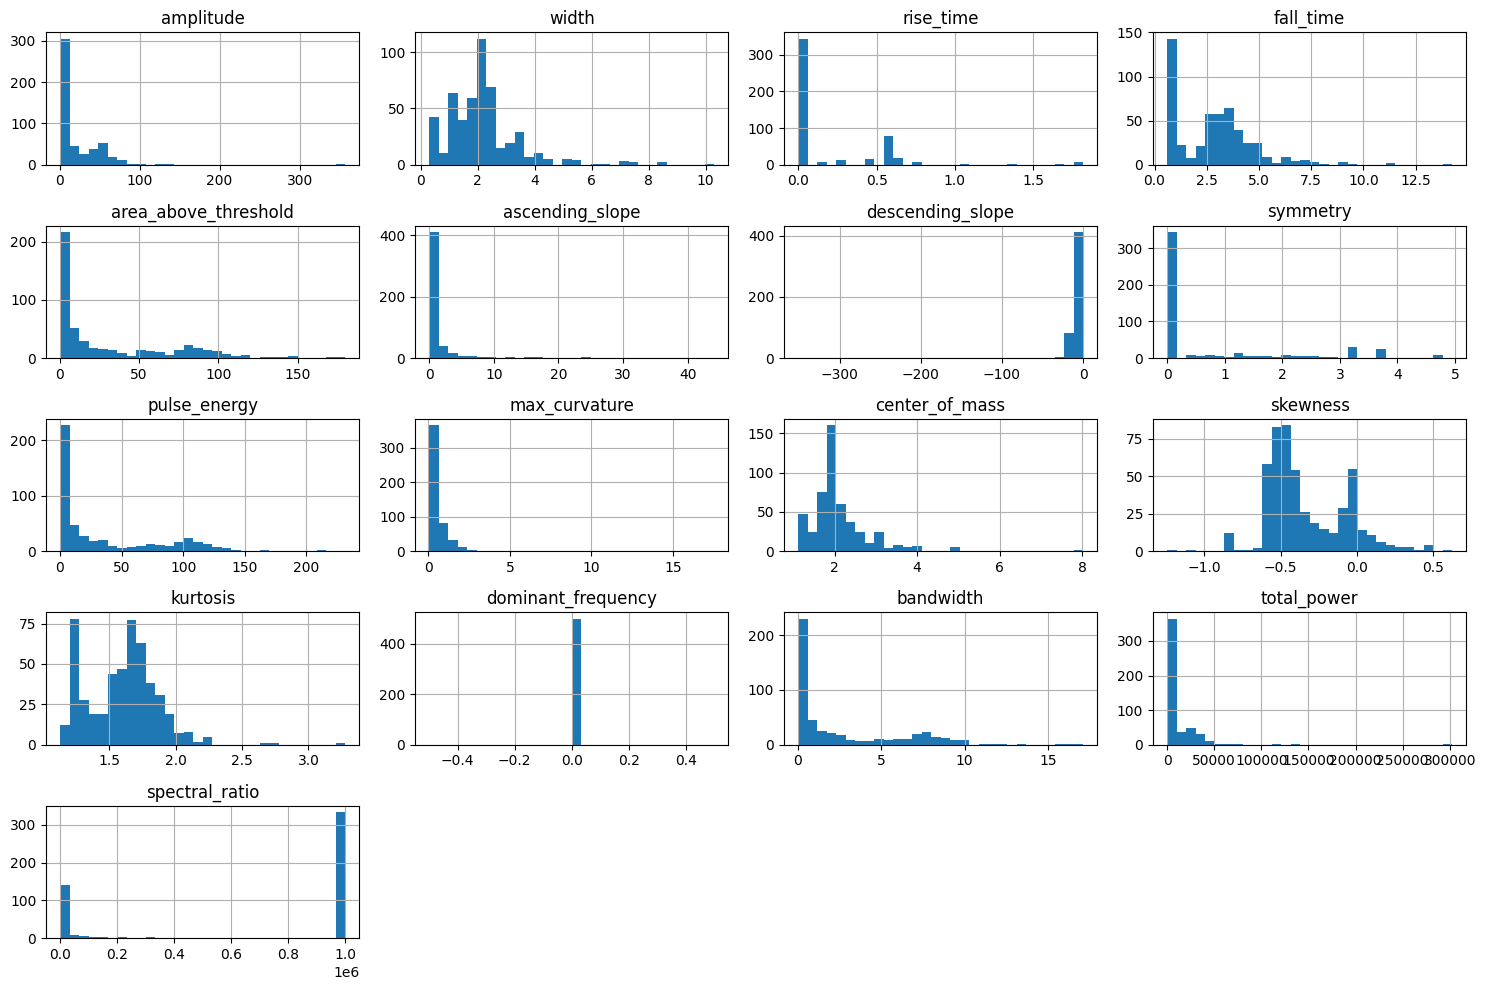

In [14]:
import matplotlib.pyplot as plt

features.hist(bins=30, figsize=(15, 10), layout=(5, 4))
plt.tight_layout()
plt.show()

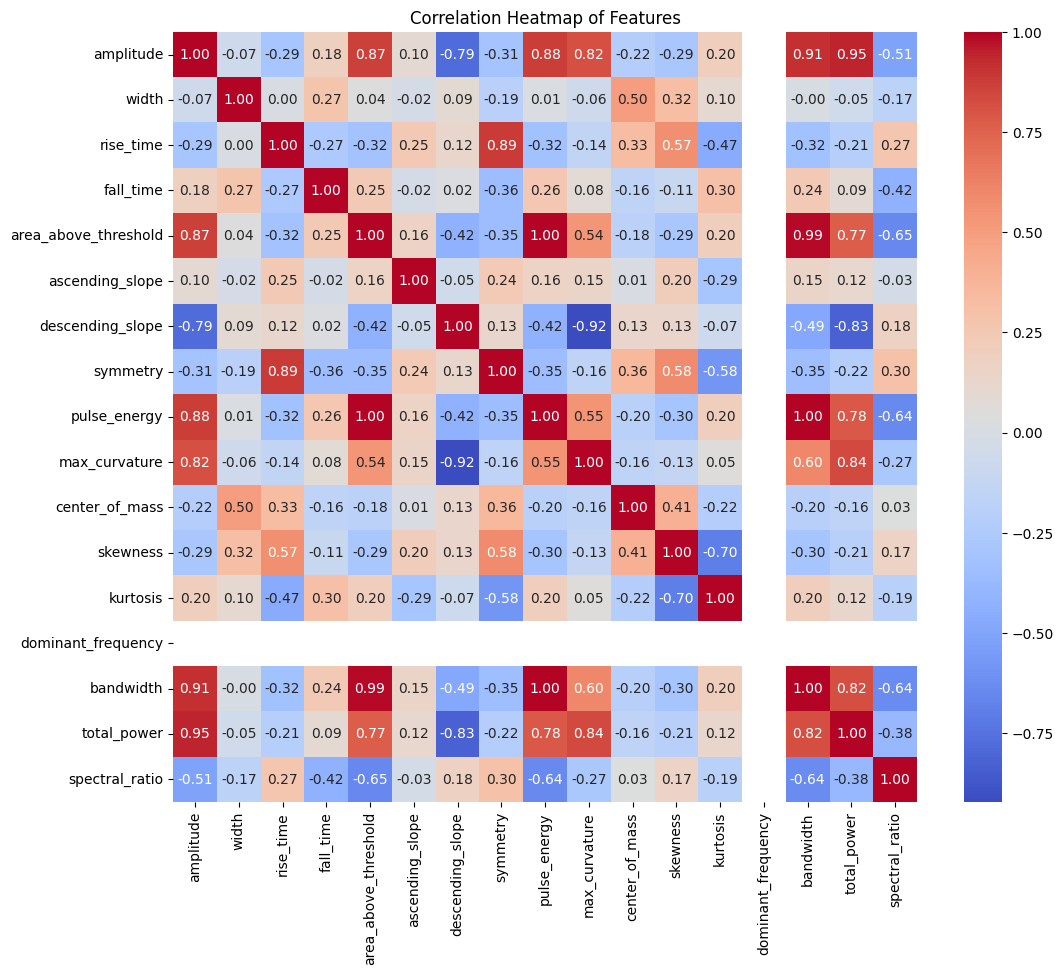

In [15]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = features.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features")
plt.show()

Explained variance ratio: [0.41441121 0.17858087 0.11498567 0.07771779]
Total explained variance: 0.7856955391904858


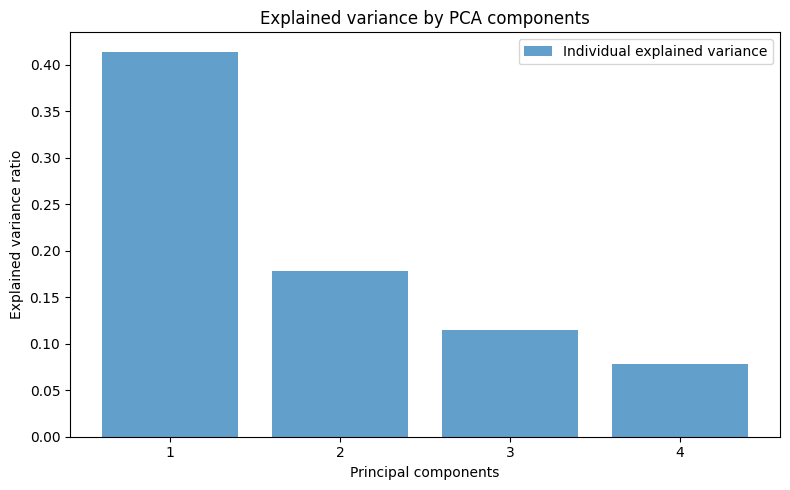

In [16]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=4)
pca_features = pca.fit_transform(scaled_features)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance}")
print(f"Total explained variance: {sum(explained_variance)}")

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained variance by PCA components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
labels_folder = os.getenv("labels_csv_path")
file_amount = 1 ## Número de archivos a cargar, 0 para cargar todos

labels_files = [
    os.path.join(root, file)
    for root, _, files in os.walk(labels_folder)
    for file in files
    if file.endswith(".csv.gz")
]

# Load all labels csv files into a dataframe
if file_amount > 0:
    labels_files = labels_files[:file_amount]
elif file_amount < 0:
    labels_files = labels_files[file_amount:]
labels_df = pd.concat([pd.read_csv(file) for file in labels_files], ignore_index=True)

print(labels_df.head())

   Unnamed: 0             class class_detailed             0
0           6           eMuonic       eMuonicP  eMuonicN_n_P
1          11  eElectromagnetic       ePhotons      ePhotons
2          13  eElectromagnetic       ePhotons      ePhotons
3          24  eElectromagnetic       ePhotons      ePhotons
4          27  eElectromagnetic       ePhotons      ePhotons


In [28]:
# Ensure the index or column used for merging is consistent
features_with_labels = features.copy()
features_with_labels['Unnamed: 0'] = data['Unnamed: 0'][:len(features)]  # Add the identifier column to features

# Merge features with labels on the 'Unnamed: 0' column
merged_df = pd.merge(features_with_labels, labels_df, on='Unnamed: 0', how='inner')

print(merged_df.head())

   amplitude     width  rise_time  fall_time  area_above_threshold  \
0  19.000000  1.818182   0.000000   3.787879             25.453040   
1   4.985753  2.575758   0.606061   1.969697              9.859895   
2   2.000000  4.242424   0.000000   1.212121              5.275569   
3   6.966905  1.969697   0.757576   4.090909             10.430124   
4   9.000000  1.818182   0.000000   2.424242             10.206657   

   ascending_slope  descending_slope  symmetry  pulse_energy  max_curvature  \
0         0.000000         -4.171936  0.000000     32.093852       0.255373   
1         2.787879         -2.042970  1.552941     10.593419       0.057044   
2         0.000000         -1.233792  0.000000      4.801336       0.204886   
3         6.182736         -1.430190  2.538462     13.420174       0.186178   
4         0.000000         -3.030180  0.000000     11.764055       0.236764   

   ...  skewness  kurtosis  dominant_frequency  bandwidth  total_power  \
0  ... -0.475596  1.705327    

In [36]:
num_classes = merged_df['class'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 3


In [29]:
from sklearn.model_selection import train_test_split

# Assuming 'merged_df' contains the features and labels
X = merged_df.drop(columns=['class', 'class_detailed', '0', 'Unnamed: 0'])  # Features
y = merged_df['class']  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 400
Testing set size: 100


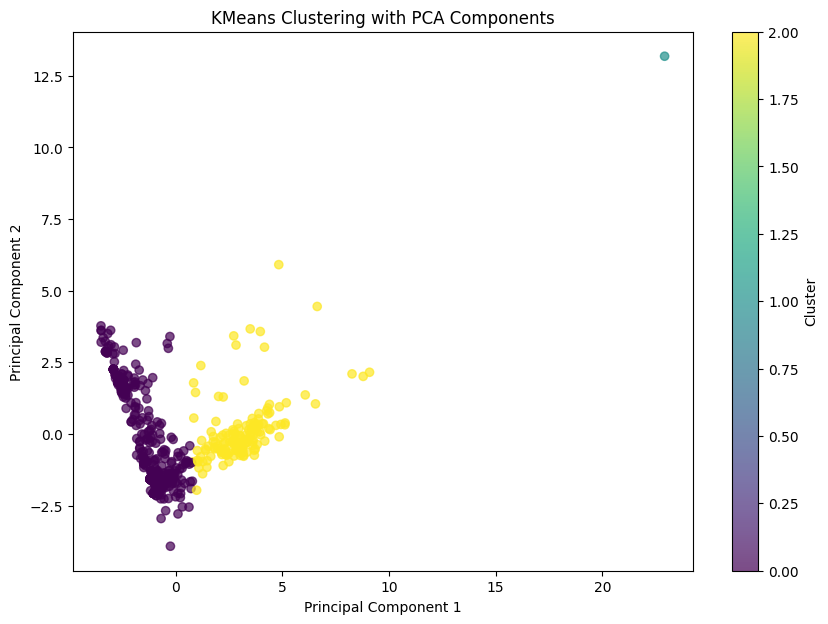

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Train KMeans clustering using PCA components
kmeans_pca = KMeans(n_clusters=3, random_state=42)
pca_features_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])
pca_features_df['cluster'] = kmeans_pca.fit_predict(pca_features)

# Plot the clusters using the first two PCA components
plt.figure(figsize=(10, 7))
plt.scatter(pca_features_df['PC1'], pca_features_df['PC2'], c=pca_features_df['cluster'], cmap='viridis', alpha=0.7)
plt.title('KMeans Clustering with PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [38]:
from sklearn.feature_selection import SelectKBest, f_classif

# Apply the filter method using ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=4)  # Select top 10 features
X_selected = selector.fit_transform(scaled_features, y)

# Get the selected feature names
selected_features = features.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

# Create a DataFrame with the selected features
selected_features_df = pd.DataFrame(X_selected, columns=selected_features)
print(selected_features_df.head())

Selected features: Index(['amplitude', 'area_above_threshold', 'pulse_energy', 'bandwidth'], dtype='object')
   amplitude  area_above_threshold  pulse_energy  bandwidth
0  -0.035853             -0.130030     -0.107782  -0.097544
1  -0.530410             -0.546049     -0.570514  -0.579897
2  -0.635776             -0.668357     -0.695171  -0.692619
3  -0.460496             -0.530836     -0.509677  -0.525785
4  -0.388749             -0.536798     -0.545320  -0.547452


/home/agustin/Documentos/Repositorios/tesis/venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [13] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/agustin/Documentos/Repositorios/tesis/venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


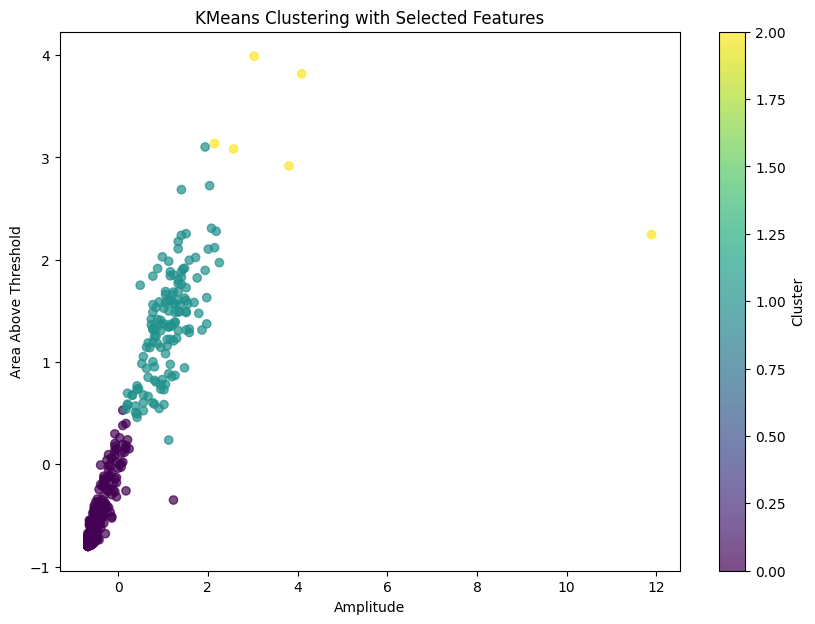

In [39]:
# Train KMeans clustering using the selected K best features
kmeans_selected = KMeans(n_clusters=3, random_state=42)
selected_features_df['cluster'] = kmeans_selected.fit_predict(selected_features_df)

# Plot the clusters using the first two selected features
plt.figure(figsize=(10, 7))
plt.scatter(selected_features_df['amplitude'], selected_features_df['area_above_threshold'], 
            c=selected_features_df['cluster'], cmap='viridis', alpha=0.7)
plt.title('KMeans Clustering with Selected Features')
plt.xlabel('Amplitude')
plt.ylabel('Area Above Threshold')
plt.colorbar(label='Cluster')
plt.show()